In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import minimize


In [97]:
# 1. Kelly Criterion Heatmap
def kelly_criterion(book_prob, model_prob):
    """Calculate Kelly fraction given book and model probabilities"""
    b = (1/book_prob) - 1  # Convert probability to decimal odds
    p = model_prob
    q = 1 - p
    return max(0, (p * (b + 1) - 1) / b)

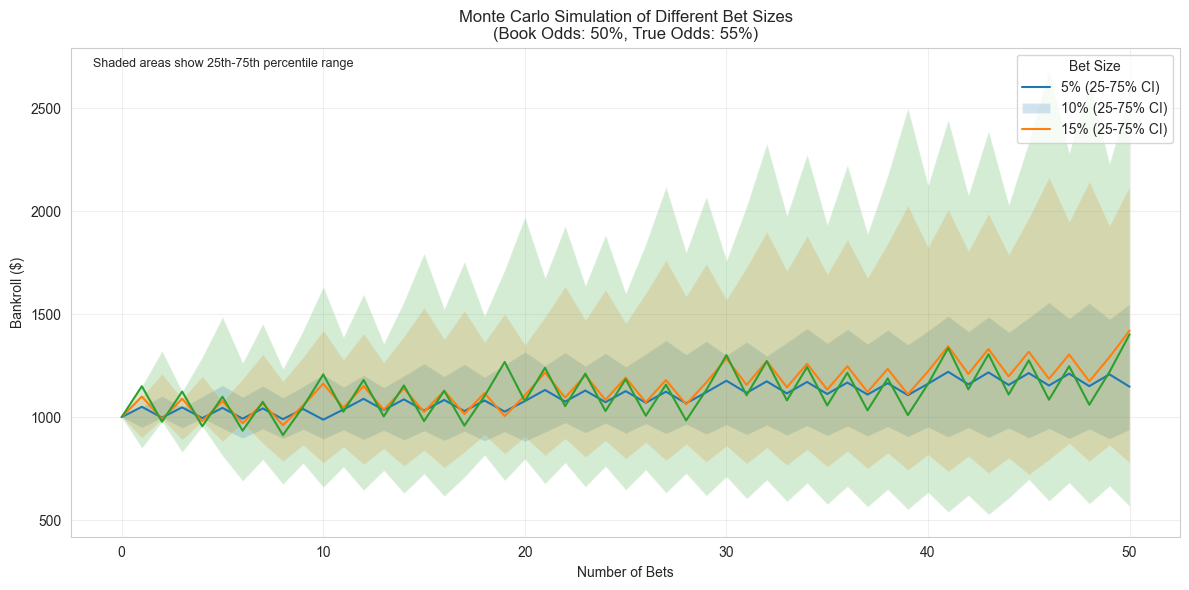

In [98]:
# Monte Carlo simulation parameters
n_iterations = 10000
n_bets = 50
initial_bankroll = 1000
bet_sizes = [0.05, 0.10, 0.15]  # 9%, 10%, 11% bet sizes
book_odds = 0.50  # Book's probability
true_odds = 0.55  # True probability

# Store results for each bet size
results = []

# Run simulation for each bet size
for bet_size in bet_sizes:
    for iteration in range(n_iterations):
        bankroll = initial_bankroll
        bet_history = [bankroll]
        
        for _ in range(n_bets):
            # Simulate bet outcome
            win = np.random.random() < true_odds
            bet_amount = bankroll * bet_size
            
            if win:
                # Win pays out at fair odds for 50% probability (2.0)
                bankroll += bet_amount
            else:
                bankroll -= bet_amount
                
            bet_history.append(bankroll)
            
        # Store results
        results.extend([{
            'Bet Number': i,
            'Bankroll': value,
            'Bet Size': f'{int(bet_size*100)}%',
            'Iteration': iteration
        } for i, value in enumerate(bet_history)])

# Convert results to DataFrame
df = pd.DataFrame(results)

# Calculate percentiles for each bet number and bet size
percentiles = df.groupby(['Bet Number', 'Bet Size'])['Bankroll'].agg(
    median='median',
    p10=lambda x: np.percentile(x, 25),
    p90=lambda x: np.percentile(x, 75)
).reset_index()

# Create plot
plt.figure(figsize=(12, 6))

# Plot lines and shaded regions for each bet size
for bet_size in bet_sizes:
    bet_size_str = f'{int(bet_size*100)}%'
    data = percentiles[percentiles['Bet Size'] == bet_size_str]
    
    plt.plot(data['Bet Number'], data['median'], label=bet_size_str)
    plt.fill_between(data['Bet Number'], 
                     data['p10'], 
                     data['p90'],
                     alpha=0.2)

plt.title('Monte Carlo Simulation of Different Bet Sizes\n(Book Odds: 50%, True Odds: 55%)')
plt.xlabel('Number of Bets')
plt.ylabel('Bankroll ($)')
plt.grid(True, alpha=0.3)
plt.legend(title='Bet Size', labels=[f'{int(bet_size*100)}% (25-75% CI)' for bet_size in bet_sizes])
plt.text(0.02, 0.98, 'Shaded areas show 25th-75th percentile range', 
         transform=plt.gca().transAxes, 
         fontsize=9,
         verticalalignment='top')
plt.tight_layout()
plt.show()


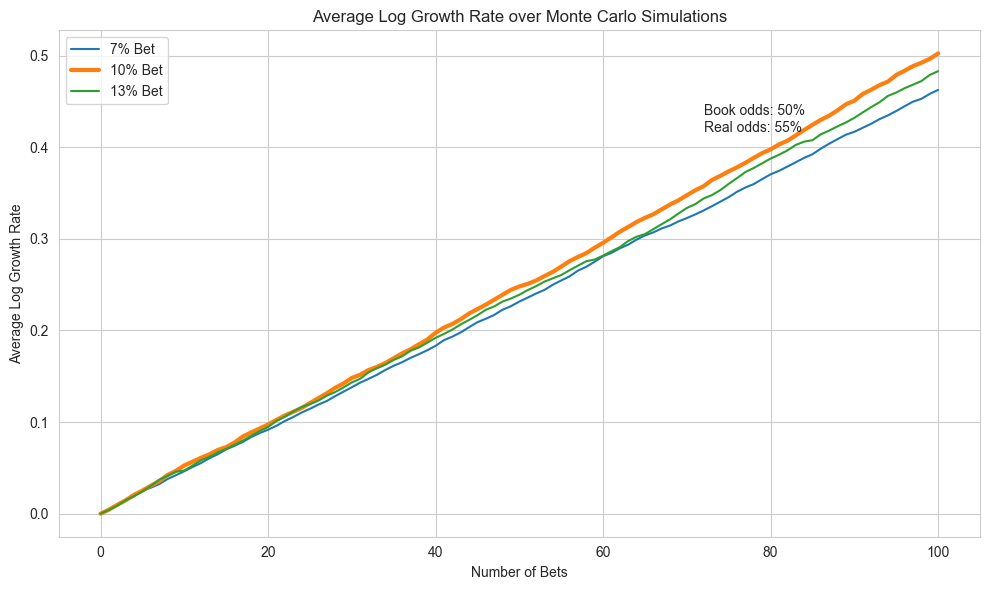

In [99]:
# Parameters
true_prob = 0.55  # True win probability
book_prob = 0.50  # Book's implied win probability
odds = 2.0        # Decimal odds for even money
n_trials = 10000  # Number of Monte Carlo simulations
n_bets = 100      # Number of bets per trial
bet_sizes = [0.07, 0.10, 0.13]  # Fraction of portfolio bet

all_bankrolls = {}

for bet_fraction in bet_sizes:
    bankrolls = np.zeros((n_trials, n_bets + 1))
    bankrolls[:, 0] = 1.0  # Initial wealth

    for i in range(n_trials):
        for j in range(1, n_bets + 1):
            win = np.random.rand() < true_prob
            if win:
                bankrolls[i, j] = bankrolls[i, j - 1] * (1 + bet_fraction * (odds - 1))
            else:
                bankrolls[i, j] = bankrolls[i, j - 1] * (1 - bet_fraction)

    all_bankrolls[bet_fraction] = bankrolls

# Plot average log growth rate
plt.figure(figsize=(10, 6))

for bet_fraction in bet_sizes:
    # Calculate log returns
    log_returns = np.log(all_bankrolls[bet_fraction]) - np.log(all_bankrolls[bet_fraction][:,[0]])
    # Calculate average log growth rate
    avg_log_growth = np.mean(log_returns, axis=0)
    
    if bet_fraction == 0.10:
        plt.plot(avg_log_growth, linewidth=3, label=f"{int(bet_fraction*100)}% Bet")
    else:
        plt.plot(avg_log_growth, label=f"{int(bet_fraction*100)}% Bet")

plt.xlabel("Number of Bets")
plt.ylabel("Average Log Growth Rate")
plt.title("Average Log Growth Rate over Monte Carlo Simulations")
plt.legend()
plt.text(0.7, 0.8, "Book odds: 50%\nReal odds: 55%", transform=plt.gca().transAxes)
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# 1. Kelly Criterion Heatmap
def kelly_criterion(book_prob, model_prob):
    """Calculate Kelly fraction given book and model probabilities"""
    b = (1/book_prob) - 1  # Convert probability to decimal odds
    p = model_prob
    q = 1 - p
    return max(0, (p * (b + 1) - 1) / b)

def create_kelly_heatmap():
    book_odds = np.arange(0.05, 0.91, 0.05)
    model_odds = np.arange(0.05, 0.96, 0.05)
    
    # Create empty matrix
    kelly_matrix = np.zeros((len(model_odds), len(book_odds)))
    
    # Specific cases to fill
    specific_cases = {
        0.50: [0.55, 0.60, 0.65],
        0.85: [0.90, 0.95]
    }
    
    for i, model in enumerate(model_odds):
        for j, book in enumerate(book_odds):
            # Only fill specific cases or within 15% above book odds
            if book in specific_cases and model in specific_cases[book]:
                kelly_matrix[i, j] = kelly_criterion(book, model)
            elif (model > book) and (model <= min(book + 0.15, 0.95)):
                kelly_matrix[i, j] = kelly_criterion(book, model)
    
    # Create heatmap
    plt.figure(figsize=(18, 12))
    ax = sns.heatmap(kelly_matrix, 
                xticklabels=[f'{x:.0%}' for x in book_odds],
                yticklabels=[f'{x:.0%}' for x in model_odds],
                cmap='RdYlGn',
                annot=True,
                fmt='.2f',
                mask=(kelly_matrix == 0))  # Mask zero values
    
    ax.invert_yaxis()
    plt.title('Kelly Bet Size (Red = Low, Green = High)')
    plt.xlabel('Book Probability')
    plt.ylabel('Model Probability')
    plt.grid(True)
    plt.show()


In [17]:

# 2. Bankroll vs Sharpe Ratio
def kelly_sharpe_plot():
    mu = np.linspace(0.01, 1.0/np.sqrt(12), 100)  # 1% to 200% of bankroll
    sigma = 1 # Standard deviation
    
    # Sharpe ratio = (expected return) / standard deviation
    fractions = mu / (sigma ** 2 + np.square(mu))
    
    plt.figure(figsize=(18, 12))
    plt.plot(fractions * 100, mu)
    plt.title('Bankroll Fraction vs. Monthly Sharpe Ratio')
    plt.xlabel('Percentage of Bankroll (%)')
    plt.ylabel('Monthly Sharpe Ratio')
    plt.grid(True, alpha=0.3)
    plt.show()


In [95]:

# 3. Kelly Portfolio Allocation
def kelly_portfolio_allocation():
    # Assumptions:
    # - 3 identical assets with 7% mean return and 50% volatility
    # - Annualized Sharpe ratio = 0.07/(0.5/sqrt(252)) ≈ 0.22 for each asset
    # - Pairwise correlations vary from -0.4 to 0.8
    # - Using pure Kelly criterion (no constraints)
    correlations = np.linspace(-0.4, 0.8, 25)
    n_assets = 3
    mu = np.array([0.07] * n_assets)  # Mean returns
    sigma = np.array([0.5] * n_assets)  # Standard deviations
    
    weights = np.zeros((len(correlations), n_assets))
    
    for i, rho in enumerate(correlations):
        # Create correlation matrix
        corr_matrix = np.ones((n_assets, n_assets)) * rho
        np.fill_diagonal(corr_matrix, 1)
        
        # Convert to covariance matrix
        cov_matrix = np.diag(sigma) @ corr_matrix @ np.diag(sigma)
        
        # Kelly optimal allocation: w = C^-1 * mu
        weights[i] = np.linalg.inv(cov_matrix) @ mu
    
    plt.figure(figsize=(12, 6))
    for i in range(n_assets):
        plt.plot(correlations, weights[:, i] * 100, label=f'Asset {i+1}')
    
    plt.title('Kelly Optimal Allocation vs Correlation\n' + 
              '(3 identical assets with annualized Sharpe ratio ≈ 0.5)')
    plt.xlabel('Pairwise Correlation')
    plt.ylabel('Portfolio Weight (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


1. Kelly Criterion Heatmap


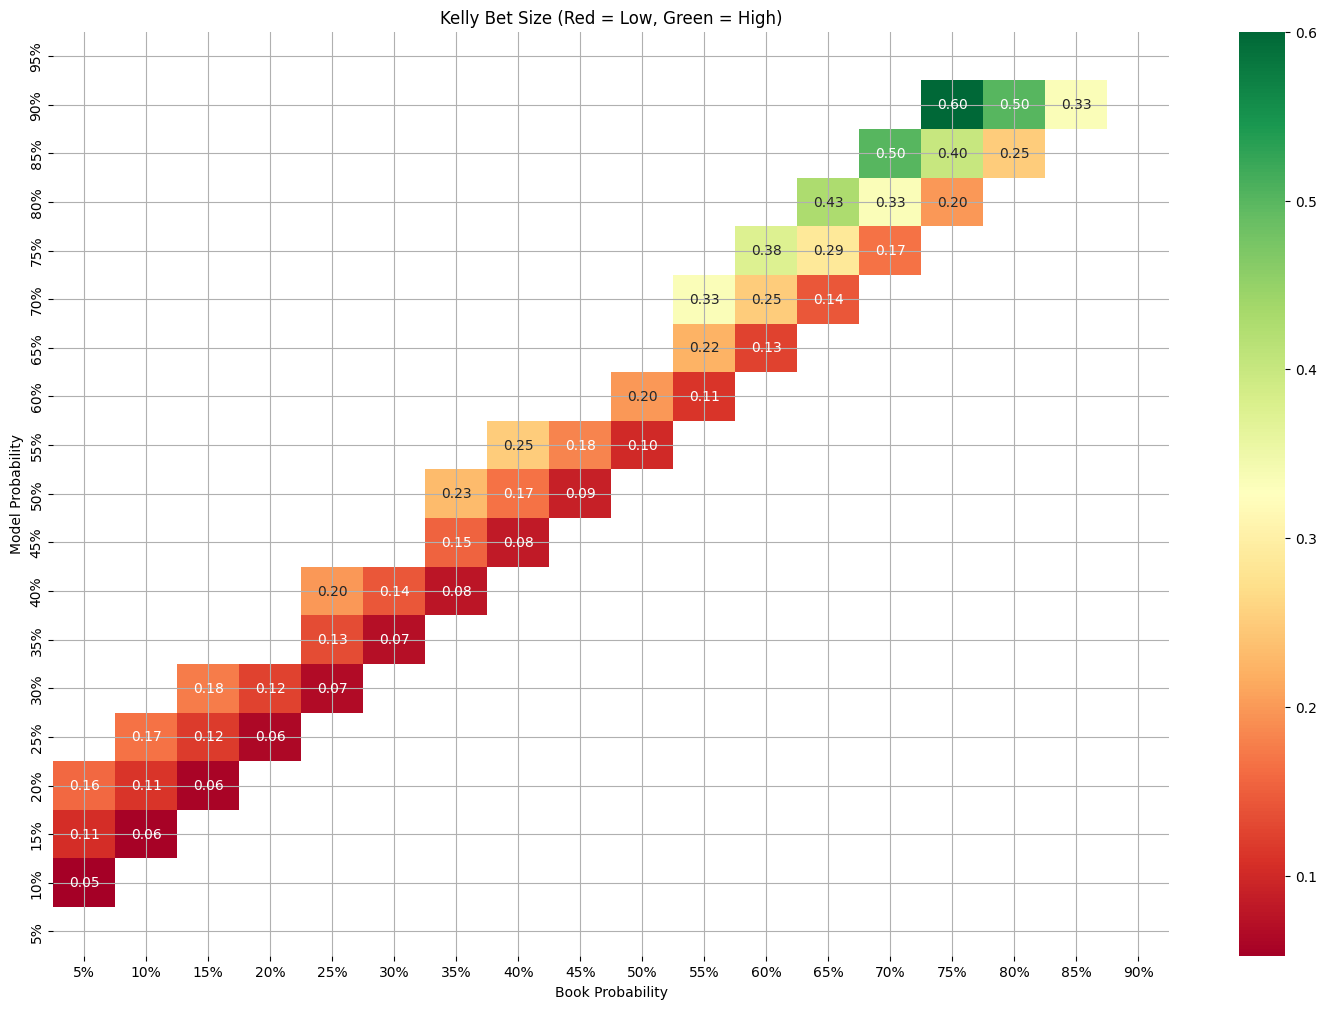

In [23]:
create_kelly_heatmap()



2. Bankroll vs Sharpe Ratio


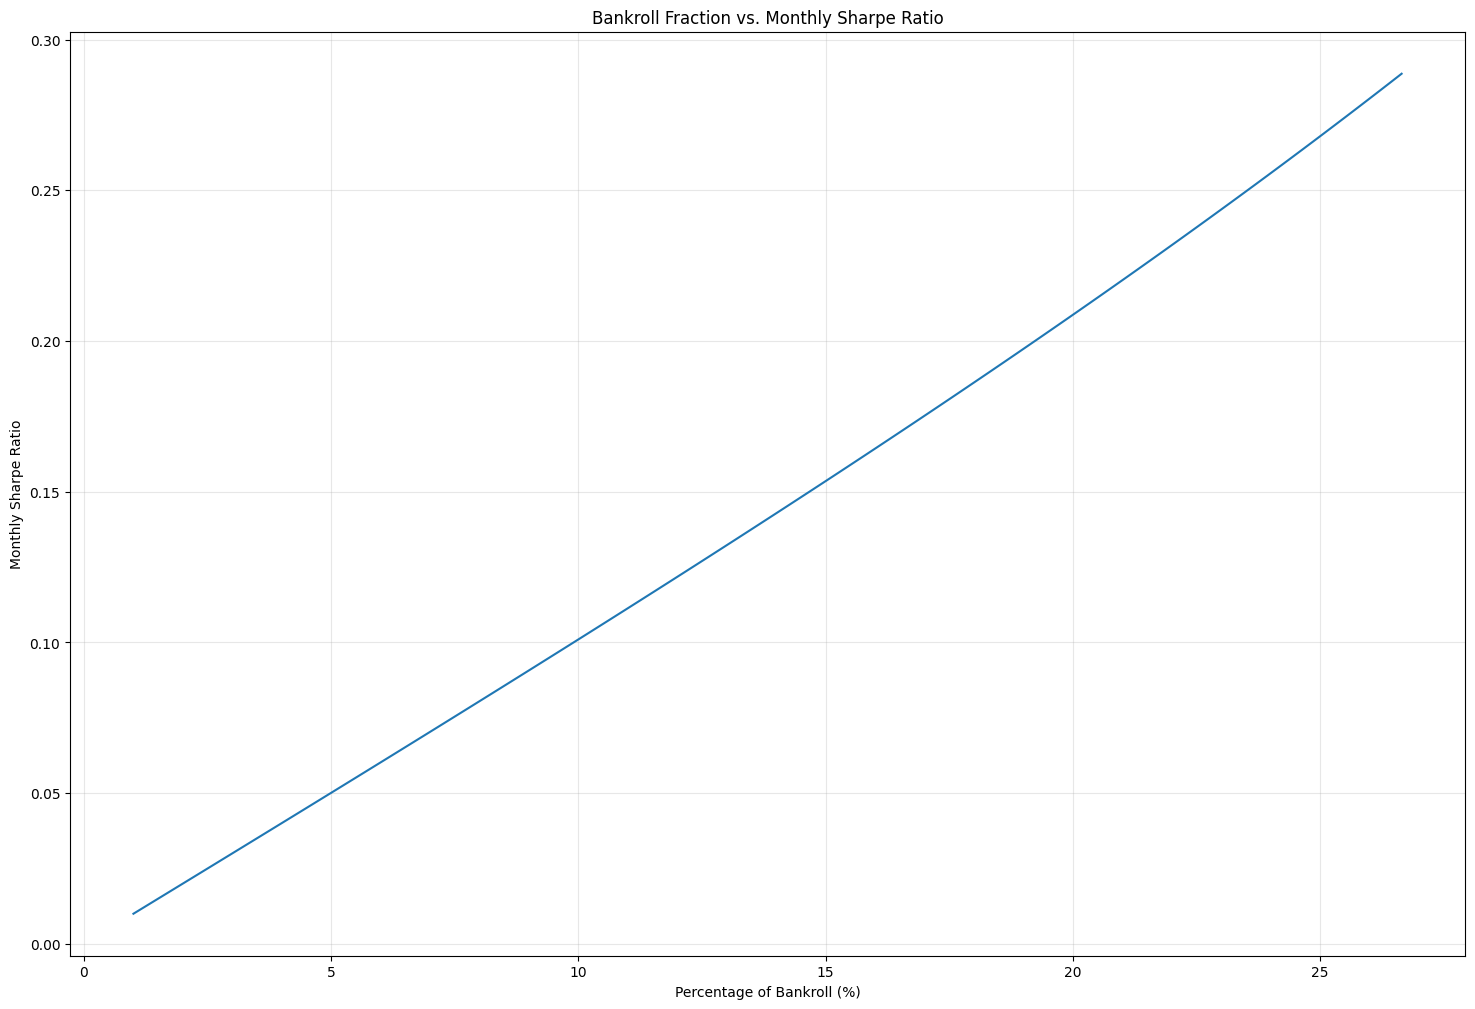

In [18]:
kelly_sharpe_plot()


3. Kelly Portfolio Allocation


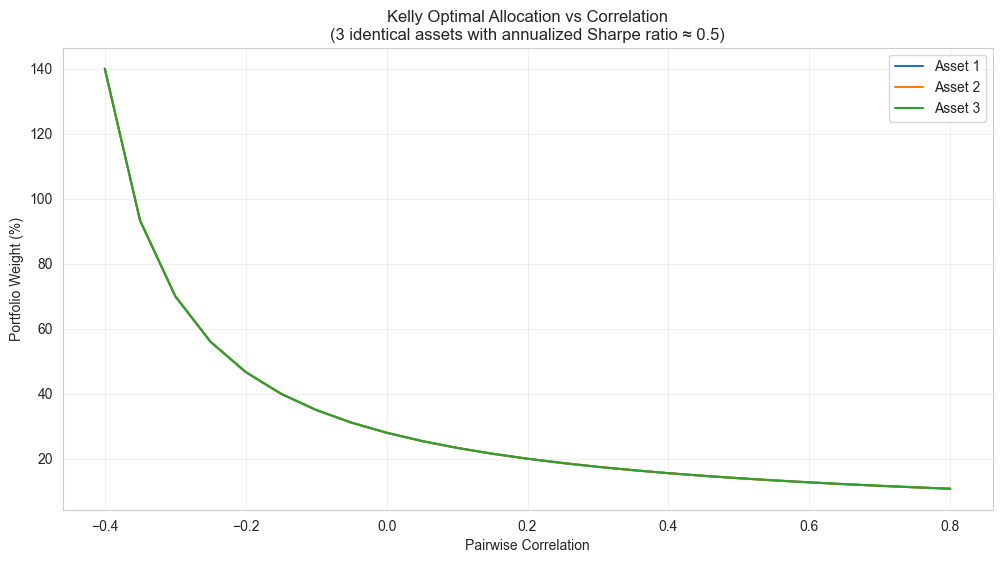

In [96]:
kelly_portfolio_allocation()